In [17]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt


Functia de extragere a trasaturilor
- redimensionare imagini la 150x150 px

In [18]:
#function to extract features from an image
def extract_features(image_path):
  #normlaize the path for proper handliing
  image_path = os.path.normpath(image_path)
  img = cv2.imread(image_path)
  if img is None:
    print(f"Error: image not found {image_path}")
    return None
  img = cv2.resize(img, (150, 150)) # resize to a fixed size
  img = img.flatten() # Flatten the image into a 1D array
  return img

Stabilirea caii de acces la Setul de Date Path

In [19]:
# Paths
csv_path = '/content/drive/MyDrive/Colab Notebooks/LAB6TIA/dataset.csv' # Path to CSV file
base_folder = '/content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS' # base folder containing

Functia pt incarcarea datelor din setul de date si preprocesarea acestora:
- conversie in format vectorial
- atribuire etichete  de clasa

In [20]:
#Function to load dataset and create pairs
def load_data_with_folders(csv_path, base_folder):
    #Read CSV
    df = pd.read_csv(csv_path, header = 0)
    folder_names = df.columns.tolist()

    pairs = []
    labels = []

    #iterate over the rows
    for _, row in df.iterrows():
        # construct full paths for each image using os.path.join
        ref_image = os.path.join(base_folder,folder_names[0], row[folder_names[0]])
        identical_image = os.path.join(base_folder,folder_names[1], row[folder_names[1]])
        unmatchimg_image = os.path.join(base_folder,folder_names[2], row[folder_names[2]])

        # Normalize paths to handle any potential issues with slashes
        ref_image = os.path.normpath(ref_image)
        identical_image = os.path.normpath(identical_image)
        unmatchimg_image = os.path.normpath(unmatchimg_image)

        # Debug: print paths
        print(f"Reference Image: {ref_image}")
        print(f"Identical Image: {identical_image}")
        print(f"Unmatching Image: {unmatchimg_image}")

        # Check if images exist and extract features
        ref_features = extract_features(ref_image)
        identical_features = extract_features(identical_image)
        unmatchimg_features = extract_features(unmatchimg_image)

        # Cehck if features extraction was succesful
        if ref_features is not None and identical_features is not None:
            # Add similar pair
            pair_features = np.abs(ref_features - identical_features)
            pairs.append(pair_features)
            labels.append(1) # Similar

        if ref_features is not None and unmatchimg_features is not None:
            # Add not similar pair
            pair_features = np.abs(ref_features - unmatchimg_features)
            pairs.append(pair_features)
            labels.append(0) # Not similar
    return np.array(pairs), np.array(labels)

Functia pt incarcare date si Antrenare si Salvare MODEL

In [21]:
# Load dataset
X, y = load_data_with_folders(csv_path, base_folder)

# Check if data is loaded correctly
if len(X) == 0 or len(y) == 0:
    print("Error: No pairs or labels found. Please check the CSV and image paths.")
else:
    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                        random_state=42)
    # Train the SVM model
    svm_classifier = SVC(kernel='linear', probability=True)
    svm_classifier.fit(X_train, y_train)

    # Save the trained model
    model_path = 'svm_image_similarity_model.pkl'
    joblib.dump(svm_classifier, model_path)

    # Evaluate the model
    y_pred = svm_classifier.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Reference Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Reference/Bill_Frist_0005.jpg
Identical Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Identical/Bill_Frist_0002.jpg
Unmatching Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Unmatching/Carl_Reiner_0001.jpg
Reference Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Reference/Bill_Fristt_0004.jpg
Identical Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Identical/Bill_Frist_0009.jpg
Unmatching Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Unmatching/Carl_Reiner_0002.jpg
Reference Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Reference/Bill_Fristtt_0002.jpg
Identical Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Identical/Bill_Fristt_0005.jpg
Unmatching Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Unmatching/Carl_Reiner_00022.jpg
Reference Image: /content/drive/MyDrive/Colab Notebooks/LAB6TIA/DS/Reference/Bob_Graham_0002.jpg
Identical Image:

Afisare pentru Predictie si afisare a rezultatelor

In [25]:
# Function to predict similarity
def predict_similarity(input_image1, input_image2, model_path):
    # Normlaize the paths for input images
    input_image1 = os.path.normpath(input_image1)
    imput_image2 = os.path.normpath(input_image2)

    # Extract features from the input images
    feature1 = extract_features(input_image1)
    feature2 = extract_features(input_image2)

    # Compute the pair representation
    pair_features = np.abs(feature1 - feature2)

    # Load the trained model
    svm_classifier = joblib.load(model_path)

    # Predict similarity
    prediction = svm_classifier.predict([pair_features])[0]
    score = svm_classifier.predict_proba([pair_features])[0][1] # Probability of being

    # Display images side-by-side
    img1=cv2.imread(input_image1)
    img2=cv2.imread(input_image2)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title('Image 1')

    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title('Image 2')

    plt.suptitle(f"Similarity: {'Yes' if prediction else 'No'}\nScore: {score:.2f}")
    plt.show()

    return prediction, score

Testare MODEL

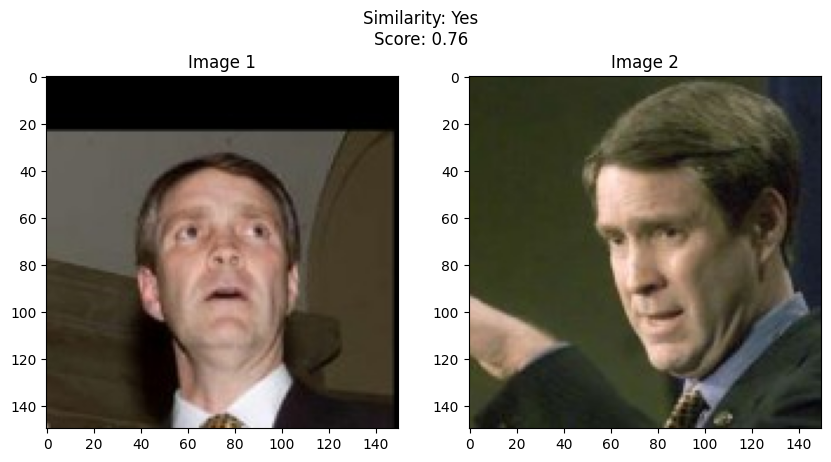

Images are similar: 1
Similarity score: 0.7608795370876805


In [26]:
# Test the model

input_image1 = '/content/drive/MyDrive/Colab Notebooks/LAB6TIA/Test/Bill_Fristtt_0004.jpg'
input_image2 = '/content/drive/MyDrive/Colab Notebooks/LAB6TIA/Test/Bill_Fristt_0005.jpg'

model_path = 'svm_image_similarity_model.pkl'

similarity, score = predict_similarity(input_image1, input_image2, model_path)
print(f"Images are similar: {similarity}")
print(f"Similarity score: {score}")